# From Algorithms to Communities in Physical Prediction, Inference, and Design
## **Jed Brown**, CU Boulder
### Natalie Beams, Leila Ghaffari, Yunhui He, Emily Jakobs, Ken Jansen, Matt Knepley, William Moses, Rezgar Shakeri, Karen Stengel, Jeremy Thompson, James Wright, Junchao Zhang


## Texas State University, 2023-01-30

## Abstract

Modeling and simulation are essential tools for modern engineering and natural sciences, leveraging domain knowledge and indirect data to create reliable causal models that can infer latent variables and optimize new products and experiments. Such models are often expressed in terms of partial differential equations and practitioners have an insatiable thirst for large-scale computation to provide sufficient accuracy, even for deterministic predictive simulation. I'll discuss ways in which modern architectures, including GPUs, have required transformational changes to data structures and abstractions, with some examples of our work in this area and deployment through community software libraries. I'll offer a view into experiences building sustainable multi-stakeholder communities around these libraries, which are foundational to simulation efforts in industry, national labs, and academia. Finally, I'll discuss academic incentives, the Journal of Open-Source Software, and a vision for expanding community software development principles and methodology to lower barriers, increase research quality, and encourage productive collaboration.

## Bio
Jed was raised by wolves in a remote part of interior Alaska. Not surprisingly, his high-school mascot was a Wolfpack, but he defected in college and earned All American honors in cross-country skiing while racing for the Nanooks (Inuit for polar bear) at the University of Alaska Fairbanks. Always fond of cold places, he wrote the Parallel Ice Sheet Model (PISM) while at UAF, and later earned a DrSc at ETH Zürich investigating computational methods for ice sheet and glacier dynamics. Gradually warming up to temperate climates, he won the 2009 Piolet d'Or climbing award for the first ascent of Xuelian West in China's Tien Shan and has subsequently solved high-temperature problems while at Argonne National Lab. He has been a developer of the Portable Extensible Toolkit for Scientific computing (PETSc) since 2008 and is the creator of libCEED, a performance-portable library for element-based algebra. He was Asst. Computational Mathematician at Argonne prior to joining the faculty at the University of Colorado Boulder in 2015. His work has been recognized by the 2014 SIAG/SC Junior Scientist Prize and a 2014 IEEE TCSC Young Achiever Award, and as co-recipient of the 2015 SIAM/ACM Prize in Computational Science and Engineering.

In [34]:
from IPython.display import SVG, Video, HTML, IFrame
import pandas as pd
import altair as alt
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

<img src="figures/mechanism-data.png" width="55%" align="center" />

# "All models are wrong, but some are useful"


## Mechanistic models let you ask: Why?
## Right (enough) for right (enough) reasons
## Explain latent variables (can't measure directly)
## Strong generalization
## When and how is model wrong?

## Partial differential equations

### Conservation
$$\newcommand{\bm}{\boldsymbol} \begin{bmatrix} \rho \\ \rho \bm u \\ E \end{bmatrix}_t + \nabla\cdot \begin{bmatrix}
\rho \bm u \\
\rho\bm u \otimes \bm u + p \bm I - \bm\sigma \\
(E + p)\bm u - \bm\sigma \cdot \bm u - k \nabla T\
\end{bmatrix}
= 0
$$

### Constitutive models
$$ (p, T) \mapsto (\rho, E - \rho \lvert\bm u\rvert^2/2) \qquad (\nabla\bm u, T) \mapsto \bm\sigma $$

# Fluids and structures have multiple time scales

Low-Mach compressible turbulence with "bad" (reflective) boundary condition

<video src="figures/fluids/P2_4znormal_1080.webm" autoplay loop />

<video src="figures/ratel/schwarz-pendulum.webm" autoplay loop />

# Implicitness

## Explicit methods

$$ u_{n+1} = u_n + \Delta t F(u_n)$$

* Simple to implement
* Must resolve the fastest time scale
  * acoustic waves
  * thermal diffusion, viscosity
  * smallest length scale of anisotropy
* Expertise needed to make it stable

## Implicit methods

$$G(u_{n+1}; u_n) = 0$$
typically solved using Newton methods
$$ J \delta u = -G(u; u_n), \qquad u \gets u + \delta u$$

* Nonlinear solvers
* Linear solvers
* Preconditioners
  * Multiscale representation
* Convergence tolerances
* Benefit depends on fast algorithms

<img src="figures/app-perf-cartoon-2.png" width="55%" />

# What is Latency?

In [28]:
IFrame("https://colin-scott.github.io/personal_website/research/interactive_latency.html", width=1800, height=700)

![](figures/acme/acme-sypd-2014.png)

### "No DOE facility through 2020 will run ACME faster than Edison" -- 2013

![Bertagna et al (2019)](figures/acme/Bertagna2019-HOMME.png)
Bertagna et al (2019)

## Fuhrer at al (2018): Near-global climate simulation at 1 km

<img src="figures/fuhrer2018-scaling-time-ann4.png" width="75%" />

# What are high order elements?

In [ ]:
def golubwelsch(n, lo=-1, hi=1, radau=False, lobatto=False):
    beta = .5 / np.sqrt(1-(2*(np.arange(1,n)))**(-2.)) # 3-term recurrence coeffs
    T = np.diag(beta,1) + np.diag(beta,-1);     # Jacobi matrix
    if radau:
        # Eq. 2.4 of Gautschi, Gauss–Radau formulae for Jacobi and Laguerre weight functions, 2000
        T[-1,-1] = 1 - 2*(n-1)**2 / (2*(n-1)*(2*(n-1)+1))
    if lobatto:
        # from Golub 1973, Some modified matrix eigenvalue problems, alpha=0
        I = np.eye(n-1)
        e = np.zeros(n-1); e[-1] = 1
        gamma = np.linalg.solve(T[:n-1,:n-1] - lo*I, e)
        mu = np.linalg.solve(T[:n-1,:n-1] - hi*I, e)
        y = np.linalg.solve(np.array([[1, -gamma[-1]], [1, -mu[-1]]]), [lo, hi])
        T[-1,-1] = y[0]
        T[-1,-2] = T[-2,-1] = np.sqrt(y[1])
    D, V = np.linalg.eigh(T);                      # Eigenvalue decomposition
    i = np.argsort(D)         # Legendre points
    x = D[i]
    w = 2*V[0,i]**2                   # Quadrature weights
    x = 0.5*((hi+lo) + (hi-lo)*x)
    w = 0.5*(hi-lo)*w
    return x, w

def fdstencil(z, x, nderiv=None):
    """Compute finite difference weights using recurrences for Lagrange polynomials (see Fornberg 1998)"""
    if nderiv is None:
        nderiv = len(x)
    x = np.array(x) - z
    k = np.arange(nderiv+1)
    c = np.outer(0.*k, x)
    c[0,0] = 1
    prod = 1
    for j in range(1,len(x)):
        dx = x[j] - x[:j]
        c[1:,j] = x[j-1]*c[1:,j-1] - k[1:]*c[:-1,j-1]
        c[0,j] = x[j-1]*c[0,j-1]
        c[:,j] *= -prod
        prod = np.prod(dx)
        c[:,j] /= prod
        c[1:,:j] = (x[j]*c[1:,:j] - k[1:,None]*c[:-1,:j]) / dx
        c[0,:j]  =  x[j]*c[0,:j] / dx
    return c

def fdvander(q, x, deriv=0):
    B = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        B[i] = fdstencil(q[i], x)[deriv]
    return B

def tabulate(p, quadrature=True):
    x = golubwelsch(p+1, lobatto=True)[0]
    if quadrature:
        xx, _ = golubwelsch(p+1)
    else:
        xx = np.linspace(-1, 1, 50)
    B = fdvander(xx, x)
    return pd.DataFrame([dict(x=xx[i], f=j, basis_value=B[i,j]) for i in range(B.shape[0]) for j in range(B.shape[1])])

In [83]:
df = tabulate(1, quadrature=False)
alt.Chart(df).mark_line().encode(
    x='x', y='basis_value', color='f:N',
).properties(height=600, width=600)

alt.Chart(...)

In [81]:
df = tabulate(4, quadrature=True)
alt.Chart(df).mark_point().encode(
    x='x', y='basis_value', color='f:N',
).properties(height=500, width=500)

alt.Chart(...)

# Sparse matrices have been centered for 50+ years

<img src="figures/EllipRCMSquare.png" width="100%" />

## Represent only nonzero elements
* Store one `int` and one `double` per nonzero

## Effective use of libraries
* Sparse direct solvers
* Algebraic multigrid
* "black-box" preconditioners
* matrix-based stabilization, etc.

### 😦 number of entries for elasticity
  
* $Q_1$: `27 * 3` components = **81**
* $Q_2$: `(27 + 3*45 + 3*75 + 125)/8 * 3` components = **192**

# Memory bandwidth and matrix-free methods

* Assembled matrices need at least 4 bytes transferred per flop. Hardware does 10 flops per byte.
* Matrix-free methods store and move less data, compute faster.

<img src="figures/karlrupp/flop-per-byte-dp-2022.svg" class="floatleft" />
<img src="figures/TensorVsAssembly-qstore.svg" class="floatright" />

# Matrix-free is faster even for lowest order ($Q_1$) elements

<img src="figures/ratel/schwarz-apply.svg" width="100%" />

## [libCEED](https://libceed.readthedocs.io): fast algebra for finite elements

* Backend plugins with run-time selection
  * debug/memcheck, optimized
  * libxsmm, CUDA, HIP
  * MAGMA to CUDA and HIP
  * OCCA to OpenMP, OpenCL, CUDA, and HIP
* Single source vanilla C for QFunctions
  * Easy to debug, understand locally, C++ optional
  * Target for DSLs, AD
* Python, Julia, Rust
* 2-clause BSD
* Available via MFEM, PETSc, Nek5000

<img src="figures/ceed/libceed-backends-tex.png" />

Thanks to many developers, including Jeremy Thompson, Yohann Dudouit, Valeria Barra, Natalie Beams,  Ahmad Abdelfattah, Leila Ghaffari, Will Pazner, Thilina Ratnayaka, Tzanio Kolev, Veselin Dobrev, David Medina

<img src="figures/ceed/libCEED-2.png" width=100% />


## Quadrature functions: the math

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    u = B_I \mathcal E_e u_L \qquad \nabla u = \frac{\partial X}{\partial x} B_{\nabla} \mathcal E_e u_L \\
    J w = \sum_e \mathcal E_e^T \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix}}_{\text{coefficients at quadrature points}} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix} \mathcal E_e w_L
\end{gather*}
  
* $B_I$ and $B_\nabla$ are tensor contractions -- independent of element geometry
* Choice of how to order and represent gathers $\mathcal E$ and scatters $\mathcal E^T$
* Similar for Neumann/Robin and nonlinear boundary conditions

## Quadrature functions: debuggable, vectorizable, and JITable

* Independent operations at each of `Q` quadrature points, order unspecified

```c
int L2residual(void *ctx, CeedInt Q,
    const CeedScalar *const in[],
    CeedScalar *const out[]) {
  const CeedScalar *u = in[0], *rho = in[1], *target = in[2];
  CeedScalar *v = out[0];
  for (CeedInt i=0; i<Q; i++)
    v[i] = rho[i] * (u[i] - target[i]);
  return 0;
}
```

![](figures/ceed/solids-perf-disassembly.png)

# Julia, Python, and Rust: safer, easier

### [Julia QFunctions](https://ceed.exascaleproject.org/libCEED-julia-docs/dev/UserQFunctions.html): defined and wired up in one place, CUDA.jl

```julia
@interior_qf apply_qfunc = (
    ceed,
    dim=dim,
    (du, :in, EVAL_GRAD, dim),
    (qdata, :in, EVAL_NONE, dim*(dim + 1)÷2),
    (dv, :out, EVAL_GRAD, dim),
    begin
        dXdxdXdxT = getvoigt(qdata)
        dv .= dXdxdXdxT*du
    end,
)
```

### [Rust packaging](https://docs.rs/libceed): `Cargo.toml` takes the pain out of dependency management
```toml
[dependencies]
libceed = "0.11.0"
```
```console
$ cargo build
```

# BP performance on CPU (2x EPYC 7452)

In [23]:
from postprocess_base import read_logs
import altair as alt
from glob import glob

runs = read_logs(glob('data/ceed/**/*.txt'))
runs['FE_nodes_per_compute_node'] = runs['num_unknowns'] / (runs['num_procs'] / runs['num_procs_node']) / runs['dof_per_node']
runs.head()

,file,backend,backend_memtype,hostname,test,num_procs,num_procs_node,degree,quadrature_pts,code,bp,case,num_unknowns,num_elem,dof_per_node,ksp_its,time_per_it,cg_iteration_dps,FE_nodes_per_compute_node
0,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 1,1,1,1,3,libCEED,1,scalar,5616,4692,1,5,0.000362,15509500.0,5616.0
1,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 2,1,1,1,3,libCEED,2,vector,16848,4692,3,5,0.000366,46092000.0,5616.0
2,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 3,1,1,1,3,libCEED,3,scalar,3872,4692,1,1,0.000499,7762750.0,3872.0
3,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 4,1,1,1,3,libCEED,4,vector,11616,4692,3,1,0.000517,22485700.0,3872.0
4,data/ceed/lassen/lassen-16-4.txt,/gpu/cuda/gen,device,lassen410,PETSc CEED Benchmark Problem 1,1,1,1,3,libCEED,1,scalar,10800,9384,1,5,0.000363,29759700.0,10800.0


In [24]:
highlight = alt.selection_single(
    on='mouseover',
    fields=['degree', 'time_per_it', 'backend', 'hostname'],
    nearest=True,
    empty='none',
)

bps_select = alt.selection_single(
    fields=['bp'],
)

base = alt.Chart(runs[runs.hostname == "noether"]).encode(
    alt.Y('mdofs:Q', title='MDoF/s per CG iteration'),
    alt.Color('degree:N'),
    alt.Size('num_unknowns', scale=alt.Scale(type='log', domain=(1e3, 1e6))),
    alt.Shape('bp:N'),
    tooltip=('hostname', 'bp', 'num_procs', 'backend', 'num_elem', 'degree', 'num_unknowns', 'file'),
).transform_filter(
    bps_select,
).transform_calculate(
    mdofs='datum.cg_iteration_dps/1e6',
)

points = base.mark_point().encode(
    opacity=alt.condition(highlight, alt.value(1), alt.value(.5)),
).add_selection(
    highlight,
)

lines = base.mark_line().encode(
    size=alt.condition(alt.datum.degree - highlight.degree == 0, alt.value(2), alt.value(1))
)

pane = points + lines

composite = (
    pane.encode(
        alt.X('time_per_it', scale=alt.Scale(type='log'), title='Time per Iteration'),
    ).properties(width=600, height=600) |
    pane.encode(
        alt.X('FE_nodes_per_compute_node', scale=alt.Scale(type='log', domain=(3e4, 1e7), clamp=True), title='FE Nodes per Compute Node'),
    ).properties(width=600, height=600)
)

activator = alt.Chart(runs).mark_point().encode(
    alt.Y('bp', title='BP'),
    alt.Shape('bp')
).add_selection(bps_select).properties(title='Selection')

activator | composite.properties(title='CEED BPs')

alt.HConcatChart(...)

# BP performance on GPU (V100)

In [25]:
base = alt.Chart(runs[runs.hostname == "lassen385"]).encode(
    alt.Y('mdofs:Q', title='MDoF/s per CG iteration'),
    alt.Color('degree:N'),
    alt.Size('num_unknowns', scale=alt.Scale(type='log', domain=(1e3, 1e6))),
    alt.Shape('bp:N'),
    tooltip=('hostname', 'bp', 'num_procs', 'backend', 'num_elem', 'degree', 'num_unknowns', 'file'),
).transform_filter(
    bps_select,
).transform_calculate(
    mdofs='datum.cg_iteration_dps/1e6',
)

points = base.mark_point().encode(
    opacity=alt.condition(highlight, alt.value(1), alt.value(.5)),
).add_selection(
    highlight,
)

lines = base.mark_line().encode(
    size=alt.condition(alt.datum.degree - highlight.degree == 0, alt.value(2), alt.value(1))
)

pane = points + lines

composite = (
    pane.encode(
        alt.X('time_per_it', scale=alt.Scale(type='log'), title='Time per Iteration'),
    ).properties(width=600, height=600) |
    pane.encode(
        alt.X('FE_nodes_per_compute_node', scale=alt.Scale(type='log', domain=(3e4, 1e7), clamp=True), title='FE Nodes per Compute Node'),
    ).properties(width=600, height=600)
)

activator = alt.Chart(runs).mark_point().encode(
    alt.Y('bp', title='BP'),
    alt.Shape('bp')
).add_selection(bps_select).properties(title='Selection')

activator | composite.properties(title='CEED BPs')

alt.HConcatChart(...)

# libCEED and PETSc asynchrony

![](figures/ceed/libceed-bp3-nsys-cuda-gen.png)

# Nonlinear solid mechanics


<video src="figures/ratel/schwarz-q2-5x5x5-t20-l2-r2.webm" width="90%" autoplay controls loop />

## Industrial state of practice

* Low order finite elements: $Q_1$ (trilinear) hexahedra, $P_2$ (quadratic) tetrahedra.
* Assembled matrices, sparse direct and algebraic multigrid solvers

## Myths

* High order doesn't help because real problems have singularities.
* Matrix-free methods are just for high order problems

# Industrial models are riddled with singularities

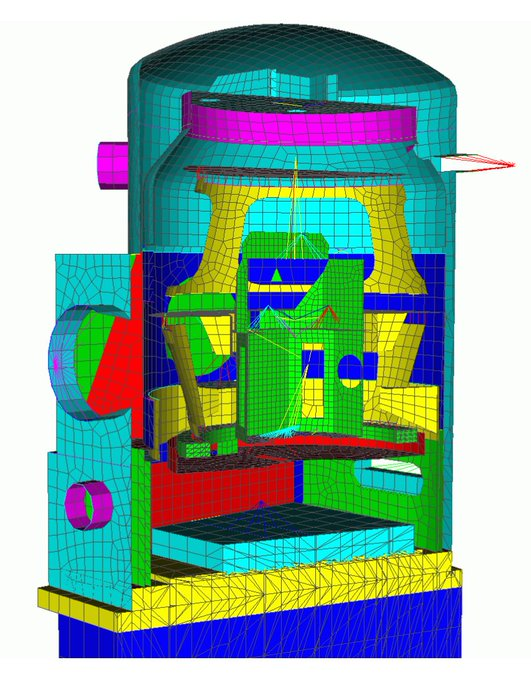

* Every reentrant corner
* Every Dirichlet (fixed/clamped) to Neumann boundary transitien


(From Bhardwaj et al, 2002.)

# $p$-multigrid algorithm and cost breakdown

<img src="figures/ratel/p-mg-cycle.png" width="80%" />

<img src="figures/ratel/op_schematic.svg" width="80%" />

In [3]:
IFrame("figures/ratel/schwarz-q2-flame.svg", width="2000", height="350")

# Nonlinear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-SNESSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-SNESSolve.svg" />

# Linear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-KSPSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-KSPSolve.svg" />

* Coarse solver is hypre BoomerAMG tuned configured for elasticity; thanks Victor Paludetto
Magri.

# Preconditioner setup efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-PCSetUp.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-PCSetUp.svg" />

# One node of Crusher vs historical Gordon Bell
## 184 MDoF $Q_2$ elements nonlinear analysis in seconds

## 2002 Gordon Bell (Bhardwaj et al)

<img src="figures/ratel/gordon-bell-2002-mems.png" width="70%" />

<img src="figures/ratel/gordon-bell-2002-mems-table.png" width="100%" />

## 2004 Gordon Bell (Adams et al)

<img src="figures/ratel/gordon-bell-2004-bone.png" width="70%" />

<img src="figures/ratel/gordon-bell-2004-bone-scaling.jpg" width="100%" />

# Same story for compressible fluid dynamics

<img src="figures/Boeing_A2_isoQspeed2_lowRes.png" width="100%" />

## PHASTA

* Extreme-scale unstructured CFD
* SUPG, implicit (gen-$\alpha$) Newton-Krylov
* Fortran code
* Aurora ESP: 2y on the "Intel/ALCF plan"
  * GPU still slower than CPU

## CEED-PHASTA

* New implementation in libCEED with PETSc
* End-to-end GPU

| Code | Arch | Element | second/step |
|---|---|---|---|
| PHASTA | Skylake | $Q_1$ | 5-10 |
| CEED | A100 | $Q_1$ | 1.0 |
| CEED | A100 | $Q_2$ | 0.7 |
| CEED | A100 | $Q_3$ | 0.5 |

<img src="figures/phypid/jeremy-thompson.jpeg" class="floatright10" />

# Preconditioners and local Fourier analysis

<img src="figures/lfatoolkit/bddc-cartoon.png" />

<img src="figures/lfatoolkit/lowVsHighDirichletBounds.png" width="80%" />

$$\kappa \le C \Big(1 + \log\big(p^2 \frac H h\big)\Big)^2$$

* https://github.com/jeremylt/LFAToolkit.jl
* Prior work in SISC 2019, SISC 2021

# Constitutive Relation Inference Toolkit

<img src="figures/crikit-workflow.svg" width="100%" />

<img src="figures/phypid/emily-jakobs.jpeg" class="floatright10" />

# Equivariant function approximation https://crikit.science

\begin{align}
\text{invariant} && \psi(\mathbf E) &= \psi(Q \mathbf E Q^T) & \forall Q \in O(3) \\
\text{equivariant} && Q \mathbf S(\mathbf E) Q^T &= \mathbf S(Q \mathbf E Q^T) & \forall Q \in O(3)
\end{align}

## Wineman-Pipkin representation

<img src="figures/wineman-pipkin.svg" />

## PSAAP: Micromorphic and grain-resolving composite inelasticity

<img src="figures/micromorph/workflow.png" />

# Bonded particulate experiments (UT Dallas, Mines)

<img src="figures/micromorph/utdallas-glass-beads.png" />

<img src="figures/micromorph/logo-footer.png" class="floatleft66" />

## Community software development

<img src="figures/ceed/libceed-badges-2021-08-03.png" class="floatleft80" />

<img src="figures/ceed/libceed-sunburst-2021-08-03.png" class="floatright10" width="20%" />

<img src="figures/PETSc/ci-pipeline.png" class="floatright20" />

<div class="floatleft80">
    
* Continuous integration: 200k unit/integration tests over 60+ environments
* Reviewer time is precious!
  * rapid feedback with modest context switching
  * focus on creative/unique aspects, automate the mundane
* Many opportunities for new contributors
* Deploy research to existing production users
</div>

# The community is the infrastructure

<img src="figures/PETSc/petsc_roles.svg" class="floatright" width="100%" />
<img src="figures/PETSc/petsc_community.svg" class="floatleft" width="100%" />

`doi:10.6084/m9.figshare.16523043`

# Why don't we have continuous integration for research papers?

<img src="https://raw.githubusercontent.com/openjournals/digital-assets/master/joss/logo/JOSS_banner_1200x446.png" class="floatright" />

# Journal of Open Source Software

### Citations are academic currency
* Research can be effectively disseminated via software
* What should be cited?
  - Web page? 10-year old methods paper? User's manual?

### JOSS: peer review for research software
* ISSN 2475-9066, CrossRef DOI
* Open, constructive review
* Developer friendly

<div style="display: flex; justify-content: space-around" class="floatright">
  <div><img src="https://joss.theoj.org/assets/osi_small-d4948474b9fbc9c73e525cf2e4b287e6ff5ff640f73ef78d1056526ba0b1dccb.png"></div>
  <div><img src="https://joss.theoj.org/assets/numfocus-3d57edde83f2e692d53f2b46508ca0011c71ad44100fa9fb11604d5d038b3c9e.png"></div>
</div>

<img src="figures/JOSS-flowchart-updated.svg" class="floatleft" />

<div class="floatright">

* Inclusive community
* Code of conduct
* Open process
* Straightforward tooling
* Assisted by **@whedon**
    
## [Costs](https://joss.theoj.org/about#costs): \$4.75/paper
* Crossref membership: \$275/year
* Portico membership: \$250/year
* Paper DOI minting: \$1/paper
* Website hosting: \$19/month
</div>

# JOSS's 1391 published papers, by month

<img src="figures/JOSS-pubs-per-month.png" />

<img src="figures/eghbal-roads-bridges.png" class="floatleft" />

<div class="floatright">
    <img src="figures/github-mars-badges.png" />
    <img src="figures/github-mars-qualifying.png" />
    
* What essential work was missed?
</div>

* Richard Byrd and Bobby Schnabel wrote libraries copied into SciPy
* NASA does lots of simulation (some using PETSc, etc.) ahead of time

<div class="floatright">
    Thanks to DOE ASCR, DOE BER, DOE ECP, DOE PSAAP III, NSF CISE for support.
</div> 
<div class="floatleft">
    
# Let's build a more accessible, productive future!
</div>

<img src="figures/phypid/phypid-group-202105.jpg" width="80%" />